In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
import io

uploaded = files.upload()

# Assuming the user uploads the correct file, get its name
for fn in uploaded.keys():
    uploaded_filename = fn
    print(f'User uploaded file "{uploaded_filename}" ({len(uploaded[fn])} bytes)')

if 'uploaded_filename' in locals():
    # Read the uploaded CSV file into a pandas DataFrame
    df = pd.read_csv(io.BytesIO(uploaded[uploaded_filename]))

    print("✅ Dataset Loaded Successfully!")
    print("Shape:", df.shape)
    display(df.head())
else:
    print("No file was uploaded. Please try again.")

Saving electric_vehicles_spec_2025.csv.csv to electric_vehicles_spec_2025.csv.csv
User uploaded file "electric_vehicles_spec_2025.csv.csv" (86210 bytes)
✅ Dataset Loaded Successfully!
Shape: (478, 22)


,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,...,NaN,496,5,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5


In [ ]:
drop_cols = ['brand', 'model', 'source_url']
df = df.drop(columns=drop_cols, errors='ignore')

# Handle missing values
df = df.fillna(df.median(numeric_only=True))
df = df.fillna("Unknown")

# Encode categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [ ]:
X = df.drop(columns=['range_km'])
y = df['range_km']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 382
Testing samples: 96


In [ ]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

xgb = XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.1, max_depth=6)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

The previous `DATA_PATH` cell (`Syf6UlfMpt5X`) is now redundant as the data has been loaded directly from the uploaded file. You can ignore or remove it if you wish.

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    return r2

r2_rf = evaluate_model(y_test, rf_pred, "Random Forest")
r2_xgb = evaluate_model(y_test, xgb_pred, "XGBoost")

best_model = rf if r2_rf > r2_xgb else xgb
best_name = "RandomForestRegressor" if best_model == rf else "XGBRegressor"
print(f"\n🏆 Best Model: {best_name}")


📈 Random Forest Performance:
MAE: 13.32
RMSE: 18.48
R² Score: 0.9677

📈 XGBoost Performance:
MAE: 11.01
RMSE: 16.26
R² Score: 0.9750

🏆 Best Model: XGBRegressor


In [ ]:
model_filename = f"{best_name}.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(best_model, f)

    print(f"✅ Model saved successfully as {model_filename}")


✅ Model saved successfully as XGBRegressor.pkl


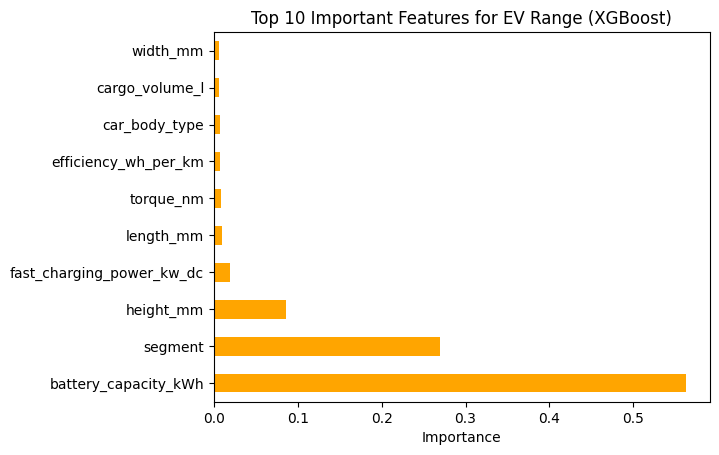

✅ Training Complete. Model Ready!


In [ ]:
if best_name == "RandomForestRegressor":
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind='barh', color='skyblue')
    plt.title("Top 10 Important Features for EV Range")
    plt.xlabel("Importance")
    plt.show()
else:
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind='barh', color='orange')
    plt.title("Top 10 Important Features for EV Range (XGBoost)")
    plt.xlabel("Importance")
    plt.show()

print("✅ Training Complete. Model Ready!")

First, we need to mount your Google Drive to this Colab notebook. This will allow the notebook to access files in your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, we will save the `XGBRegressor.pkl` file into a specific folder in your Google Drive. I'll create a folder named `colab_files` in your Drive, and save it there. You can change the `drive_path` if you prefer a different location.

In [ ]:
# Create and download the requirements.txt file
from google.colab import files

requirements_content = """
pandas
numpy
matplotlib
seaborn
scikit-learn
xgboost
pickle
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements_content)

files.download('requirements.txt')
print("✅ Created and downloaded requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Created and downloaded requirements.txt


You can also find `requirements.txt` in your Google Drive at `/content/drive/MyDrive/colab_files/requirements.txt` if direct downloads are not working well for you.